In [3]:
from MultKAN import *
from utils import *
from spline import *

checkpoint directory created: ./model
saving model version 0.0


description:   0%|                                                           | 0/20 [00:00<?, ?it/s]

| train_loss: 2.17e-02 | test_loss: 2.14e-02 | reg: 1.12e+01 | : 100%|█| 20/20 [00:03<00:00,  6.65it


saving model version 0.1


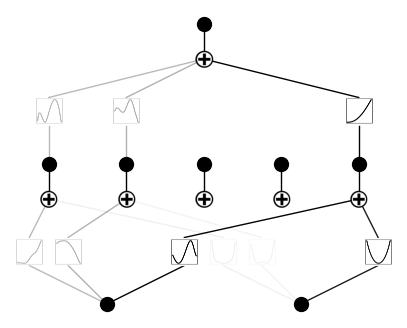

In [2]:
model = KAN(width=[2,5,1], grid=5, k=3, noise_scale=0.3, seed=2)
f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
dataset = create_dataset(f, n_var=2)
model.fit(dataset, opt='LBFGS', steps=20, lamb=0.001);
model.plot()

In [14]:
# current_dir = os.path.dirname(__file__)
import warnings
warnings.filterwarnings("ignore")

def treasury_data_retrieval(file_name):
    # file_path = os.path.join(current_dir, '..', 'data', file_name)

    df = pd.read_csv(file_name)
    df['Date'] = pd.to_datetime(df['Date'])
    df.sort_values(by='Date', ascending=True, inplace=True)
    df = df.reset_index(drop=True)

    return df 

def direct_pred_retrieval():
    data = treasury_data_retrieval('us_treasury_rates_large.csv')
    data = data.set_index('Date')
    targets = data.columns

    # List of moving average windows
    window_list = [1, 3, 5]

    # List of lags to calculate moving average
    lag_list = [1]

    # List of future date values
    shift_list = [_ for _ in range(20)]

    # Generate future columns
    for shift in shift_list:
        for col in targets:
            data[f'{col}_+_{shift}'] = data[col].shift(-shift)

    # Generate past moving average columns
    for lag in lag_list:
        for window in window_list:
            for col in targets:
                data[f'{col}_-_{lag}_window_{window}'] = data[col].shift(1).rolling(window).mean()
    return data, targets

df = direct_pred_retrieval()[0]
df.head()

,1 Mo,2 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,...,3 Mo_-_1_window_5,6 Mo_-_1_window_5,1 Yr_-_1_window_5,2 Yr_-_1_window_5,3 Yr_-_1_window_5,5 Yr_-_1_window_5,7 Yr_-_1_window_5,10 Yr_-_1_window_5,20 Yr_-_1_window_5,30 Yr_-_1_window_5
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,2.40,2.40,2.42,2.51,2.60,2.50,2.47,2.49,2.56,2.66,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-03,2.42,2.42,2.41,2.47,2.50,2.39,2.35,2.37,2.44,2.56,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-04,2.40,2.42,2.42,2.51,2.57,2.50,2.47,2.49,2.56,2.67,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-07,2.42,2.42,2.45,2.54,2.58,2.53,2.51,2.53,2.60,2.70,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-08,2.40,2.42,2.46,2.54,2.60,2.58,2.57,2.58,2.63,2.73,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
data = df.iloc[-5:, :12]
data.head()

,1 Mo,2 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
Date,,,,,,,,,,,,
2024-12-02,4.75,4.63,4.51,4.43,4.30,4.17,4.11,4.08,4.13,4.19,4.46,4.36
2024-12-03,4.66,4.56,4.49,4.40,4.27,4.17,4.13,4.11,4.17,4.23,4.50,4.40
2024-12-04,4.65,4.54,4.47,4.38,4.23,4.13,4.09,4.07,4.13,4.19,4.45,4.35
2024-12-05,4.59,4.53,4.46,4.38,4.23,4.15,4.10,4.07,4.12,4.17,4.43,4.33
2024-12-06,4.57,4.50,4.42,4.34,4.19,4.10,4.05,4.03,4.09,4.15,4.42,4.34


In [42]:
dtype = torch.get_default_dtype()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ts = torch.from_numpy(data.values).type(dtype).to(device)
ts

tensor([[4.7500, 4.6300, 4.5100, 4.4300, 4.3000, 4.1700, 4.1100, 4.0800, 4.1300,
         4.1900, 4.4600, 4.3600],
        [4.6600, 4.5600, 4.4900, 4.4000, 4.2700, 4.1700, 4.1300, 4.1100, 4.1700,
         4.2300, 4.5000, 4.4000],
        [4.6500, 4.5400, 4.4700, 4.3800, 4.2300, 4.1300, 4.0900, 4.0700, 4.1300,
         4.1900, 4.4500, 4.3500],
        [4.5900, 4.5300, 4.4600, 4.3800, 4.2300, 4.1500, 4.1000, 4.0700, 4.1200,
         4.1700, 4.4300, 4.3300],
        [4.5700, 4.5000, 4.4200, 4.3400, 4.1900, 4.1000, 4.0500, 4.0300, 4.0900,
         4.1500, 4.4200, 4.3400]])

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_lsq_spline, BSpline

# Assume `data` is a DataFrame with numerical values
# obj = data.head(1).values.flatten()  # Extract first row as an array
x = np.array([1/12, 2/12, 3/12, 6/12, 1, 2, 3, 5, 7, 10, 20, 30])
y = data.head(1).values.flatten()  # Extract first row as an array

# Define knots (assuming `knots` is predefined)
k = 3  # Cubic B-spline
t = np.linspace(-1, 31, 1)

# Fit B-Spline
spline = make_lsq_spline(x, y, t, k)

# if k > 0 and np.any((x < t[k]) | (x > t[-k])): > 1643     raise ValueError('Out of bounds w/ x = %s.' % x)
# Generate smooth values for plotting
knots_fine = np.linspace(min(knots), max(knots), 100)
y_fine = spline(knots_fine)  # Evaluate B-spline

# Plot the interpolation
plt.figure(figsize=(8, 5))
plt.plot(knots, obj, 'ro', label='Original Data')  # Original points
plt.plot(knots_fine, y_fine, 'b-', label='B-Spline Fit')  # B-Spline curve
plt.xlabel('Knots')
plt.ylabel('Values')
plt.title('B-Spline Interpolation')
plt.legend()
plt.grid(True)
plt.show()
print(x)
print(t)




IndexError: index 3 is out of bounds for axis 0 with size 1

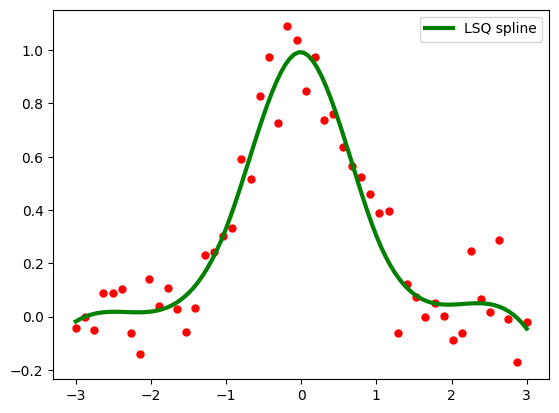

In [79]:
import numpy as np
import matplotlib.pyplot as plt
rng = np.random.default_rng()
x = np.linspace(-3, 3, 50)
y = np.exp(-x**2) + 0.1 * rng.standard_normal(50)

from scipy.interpolate import make_lsq_spline, BSpline
t = [-1, 0, 1]
k = 3
t = np.r_[(x[0],)*(k+1),
          t,
          (x[-1],)*(k+1)]
spl = make_lsq_spline(x, y, t, k)

xs = np.linspace(-3, 3, 100)
plt.plot(x, y, 'ro', ms=5)
plt.plot(xs, spl(xs), 'g-', lw=3, label='LSQ spline')
# plt.plot(xs, spl_i(xs), 'b-', lw=3, alpha=0.7, label='interp spline')
plt.legend(loc='best')
plt.show()

In [80]:
print(x)
print(t)

[-3.         -2.87755102 -2.75510204 -2.63265306 -2.51020408 -2.3877551
 -2.26530612 -2.14285714 -2.02040816 -1.89795918 -1.7755102  -1.65306122
 -1.53061224 -1.40816327 -1.28571429 -1.16326531 -1.04081633 -0.91836735
 -0.79591837 -0.67346939 -0.55102041 -0.42857143 -0.30612245 -0.18367347
 -0.06122449  0.06122449  0.18367347  0.30612245  0.42857143  0.55102041
  0.67346939  0.79591837  0.91836735  1.04081633  1.16326531  1.28571429
  1.40816327  1.53061224  1.65306122  1.7755102   1.89795918  2.02040816
  2.14285714  2.26530612  2.3877551   2.51020408  2.63265306  2.75510204
  2.87755102  3.        ]
[-3. -3. -3. -3. -1.  0.  1.  3.  3.  3.  3.]
